## Loading pre-trained Word2Vec Model

In [1]:
import gensim.downloader as api

# Load the pretrained Word2Vec model
model = api.load('word2vec-google-news-300')

## Similar words for each word

In [2]:
# Define the words
words = ['computer', 'fruit', 'city', 'music', 'animal']

# Find similar words for each of these 5 words
for word in words:
    similar_words = model.most_similar(word, topn=5)
    print(f"Words similar to '{word}':")
    for similar_word in similar_words:
        print(f"  {similar_word[0]}: {similar_word[1]:.4f}")
    print()


Words similar to 'computer':
  computers: 0.7979
  laptop: 0.6640
  laptop_computer: 0.6549
  Computer: 0.6473
  com_puter: 0.6082

Words similar to 'fruit':
  fruits: 0.7737
  cherries: 0.6904
  berries: 0.6854
  pears: 0.6825
  citrus_fruit: 0.6695

Words similar to 'city':
  citys: 0.6804
  mayor: 0.6751
  town: 0.6724
  municipality: 0.6531
  municipal: 0.6223

Words similar to 'music':
  classical_music: 0.7198
  jazz: 0.6835
  Music: 0.6596
  Without_Donny_Kirshner: 0.6416
  songs: 0.6396

Words similar to 'animal':
  animals: 0.7875
  Animal: 0.7282
  animal_welfare: 0.6636
  dog: 0.6438
  pet: 0.6338



In [3]:
# Define analogy examples
analogies = [
    ('king', 'man', 'woman', 'queen'),
    ('Paris', 'France', 'Germany', 'Berlin'),
    ('walking', 'walk', 'run', 'running')
]

# Test analogy examples
for a, b, c, expected in analogies:
    predicted = model.most_similar(positive=[a, c], negative=[b], topn=1)[0][0]
    print(f"{a} - {b} + {c} ~= {predicted} (expected: {expected})")


king - man + woman ~= queen (expected: queen)
Paris - France + Germany ~= Berlin (expected: Berlin)
walking - walk + run ~= running (expected: running)


In [5]:
import numpy as np
import pandas as pd

In [6]:
data=pd.read_csv('IMDB Dataset.csv')

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Pre-processing

In [7]:
data_info = data.info()
data_head = data.head()
data_sentiment_distribution = data['sentiment'].value_counts()

data_info, data_head, data_sentiment_distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


(None,
                                               review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
 positive    25000
 negative    25000
 Name: sentiment, dtype: int64)

In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# Function to clean review text
def clean_review(review):
    # Tokenize the review text
    words = word_tokenize(review.lower())
    # Remove stopwords and punctuation
    filtered_words = [word for word in words if word not in stop_words and word not in punctuations]
    return ' '.join(filtered_words)

# Apply the clean_review function to the review column
data['cleaned_review'] = data['review'].apply(clean_review)

# Display the first few cleaned reviews
cleaned_reviews_sample = data['cleaned_review'].head()
cleaned_reviews_sample

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically 's family little boy jake thinks 's ...
4    petter mattei 's `` love time money '' visuall...
Name: cleaned_review, dtype: object

In [9]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_average_vector(review, model):
    words = review.split()
    feature_vector = np.zeros(model.vector_size, dtype='float32')
    num_words = 0
    for word in words:
        if word in model.wv:
            feature_vector = np.add(feature_vector, model.wv[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector


## Skip-gram model

F1-score: 87.89%


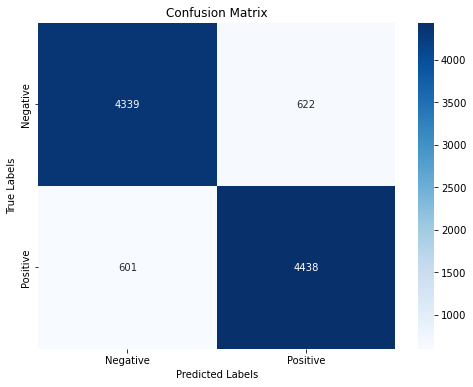

In [10]:
# skip gram model
tokenized_reviews = [review.split() for review in data['cleaned_review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, sg=1, workers=4)

X = np.array([get_average_vector(review, word2vec_model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Step 3: Train a sentiment classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## CBOW Model

F1-score: 86.26%


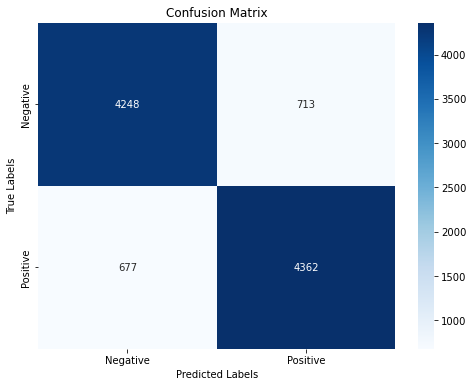

In [11]:
# CBOW model
tokenized_reviews = [review.split() for review in data['cleaned_review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, sg=0, workers=4)

X = np.array([get_average_vector(review, word2vec_model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Step 3: Train a sentiment classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Pre-trained Model

F1-score: 85.30%


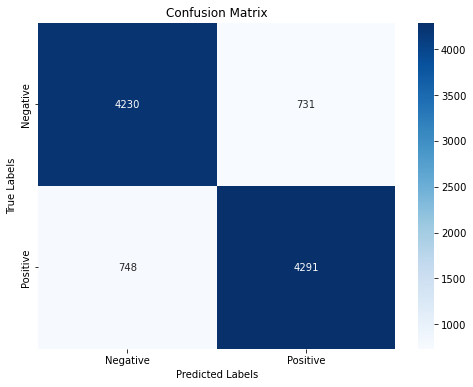

In [13]:
# Pre trained model
model = api.load('word2vec-google-news-300')

def get_pretrained_average_vector(review, model):
    words = review.split()
    feature_vector = np.zeros(model.vector_size, dtype='float32')
    num_words = 0
    for word in words:
        if word in model:
            feature_vector = np.add(feature_vector, model[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

X = np.array([get_pretrained_average_vector(review, model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Step 3: Train a sentiment classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()